# Stochastic Differential Equations: Theory and Simulation

## 1. Introduction

Stochastic Differential Equations (SDEs) are differential equations in which one or more terms incorporate a stochastic process, resulting in solutions that are themselves stochastic processes. SDEs are fundamental in modeling systems subject to random fluctuations, with applications spanning physics (Brownian motion, thermal noise), finance (stock price dynamics), biology (population dynamics with environmental noise), and engineering (control systems with uncertainty).

## 2. Mathematical Foundation

### 2.1 Brownian Motion (Wiener Process)

The foundation of SDE theory rests on the **Wiener process** $W_t$, a continuous-time stochastic process with the following properties:

1. $W_0 = 0$ (starts at zero)
2. $W_t$ has **independent increments**: for $0 \leq s < t$, $W_t - W_s$ is independent of $\{W_u : 0 \leq u \leq s\}$
3. $W_t - W_s \sim \mathcal{N}(0, t-s)$ (Gaussian increments with variance equal to time difference)
4. $W_t$ has continuous sample paths almost surely

### 2.2 Itô Stochastic Differential Equation

A general **Itô SDE** takes the form:

$$dX_t = \mu(X_t, t)\,dt + \sigma(X_t, t)\,dW_t$$

where:
- $X_t$ is the stochastic process we wish to model
- $\mu(X_t, t)$ is the **drift coefficient** (deterministic trend)
- $\sigma(X_t, t)$ is the **diffusion coefficient** (volatility/noise amplitude)
- $dW_t$ is the differential of the Wiener process

The integral form is:

$$X_t = X_0 + \int_0^t \mu(X_s, s)\,ds + \int_0^t \sigma(X_s, s)\,dW_s$$

### 2.3 Itô's Lemma

For a twice continuously differentiable function $f(X_t, t)$, **Itô's lemma** provides:

$$df = \left(\frac{\partial f}{\partial t} + \mu\frac{\partial f}{\partial x} + \frac{1}{2}\sigma^2\frac{\partial^2 f}{\partial x^2}\right)dt + \sigma\frac{\partial f}{\partial x}\,dW_t$$

This is the stochastic analogue of the chain rule, with the crucial $\frac{1}{2}\sigma^2\frac{\partial^2 f}{\partial x^2}$ term arising from the quadratic variation of the Wiener process.

## 3. Classic SDE Models

### 3.1 Geometric Brownian Motion (GBM)

Used extensively in financial modeling (Black-Scholes model):

$$dS_t = \mu S_t\,dt + \sigma S_t\,dW_t$$

**Analytical solution** (via Itô's lemma on $\ln S_t$):

$$S_t = S_0 \exp\left[\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma W_t\right]$$

### 3.2 Ornstein-Uhlenbeck Process

Models mean-reverting behavior (e.g., interest rates, velocity of particles):

$$dX_t = \theta(\mu - X_t)\,dt + \sigma\,dW_t$$

where $\theta > 0$ is the mean-reversion rate and $\mu$ is the long-term mean.

**Analytical solution**:

$$X_t = X_0 e^{-\theta t} + \mu(1 - e^{-\theta t}) + \sigma\int_0^t e^{-\theta(t-s)}\,dW_s$$

## 4. Numerical Methods for SDEs

### 4.1 Euler-Maruyama Method

The simplest numerical scheme for SDEs, analogous to Euler's method for ODEs:

$$X_{n+1} = X_n + \mu(X_n, t_n)\Delta t + \sigma(X_n, t_n)\Delta W_n$$

where $\Delta W_n = W_{t_{n+1}} - W_{t_n} \sim \mathcal{N}(0, \Delta t)$.

**Strong convergence order**: $\mathcal{O}(\sqrt{\Delta t})$

**Weak convergence order**: $\mathcal{O}(\Delta t)$

### 4.2 Milstein Method

Higher-order scheme including the Itô-Taylor expansion:

$$X_{n+1} = X_n + \mu\Delta t + \sigma\Delta W_n + \frac{1}{2}\sigma\sigma'\left[(\Delta W_n)^2 - \Delta t\right]$$

where $\sigma' = \frac{\partial\sigma}{\partial x}$.

**Strong convergence order**: $\mathcal{O}(\Delta t)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for publication-quality figures
plt.rcParams.update({
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'legend.fontsize': 10,
    'figure.figsize': (12, 10),
    'lines.linewidth': 1.5
})

In [2]:
def euler_maruyama(mu_func, sigma_func, x0, t_span, dt, n_paths=1):
    """
    Euler-Maruyama method for solving SDEs.
    
    Parameters:
    -----------
    mu_func : callable
        Drift coefficient function mu(x, t)
    sigma_func : callable
        Diffusion coefficient function sigma(x, t)
    x0 : float
        Initial condition
    t_span : tuple
        (t_start, t_end)
    dt : float
        Time step
    n_paths : int
        Number of sample paths to simulate
    
    Returns:
    --------
    t : ndarray
        Time grid
    X : ndarray
        Solution paths, shape (n_steps+1, n_paths)
    """
    t_start, t_end = t_span
    n_steps = int((t_end - t_start) / dt)
    t = np.linspace(t_start, t_end, n_steps + 1)
    
    # Initialize solution array
    X = np.zeros((n_steps + 1, n_paths))
    X[0, :] = x0
    
    # Generate Wiener increments: dW ~ N(0, dt)
    dW = np.random.normal(0, np.sqrt(dt), (n_steps, n_paths))
    
    # Euler-Maruyama iteration
    for i in range(n_steps):
        X[i+1, :] = X[i, :] + mu_func(X[i, :], t[i]) * dt + sigma_func(X[i, :], t[i]) * dW[i, :]
    
    return t, X


def milstein(mu_func, sigma_func, sigma_prime_func, x0, t_span, dt, n_paths=1):
    """
    Milstein method for solving SDEs (higher-order accuracy).
    
    Parameters:
    -----------
    mu_func : callable
        Drift coefficient function mu(x, t)
    sigma_func : callable
        Diffusion coefficient function sigma(x, t)
    sigma_prime_func : callable
        Derivative of sigma with respect to x
    x0 : float
        Initial condition
    t_span : tuple
        (t_start, t_end)
    dt : float
        Time step
    n_paths : int
        Number of sample paths to simulate
    
    Returns:
    --------
    t : ndarray
        Time grid
    X : ndarray
        Solution paths
    """
    t_start, t_end = t_span
    n_steps = int((t_end - t_start) / dt)
    t = np.linspace(t_start, t_end, n_steps + 1)
    
    X = np.zeros((n_steps + 1, n_paths))
    X[0, :] = x0
    
    dW = np.random.normal(0, np.sqrt(dt), (n_steps, n_paths))
    
    for i in range(n_steps):
        sigma_val = sigma_func(X[i, :], t[i])
        sigma_prime_val = sigma_prime_func(X[i, :], t[i])
        
        # Milstein correction term
        correction = 0.5 * sigma_val * sigma_prime_val * (dW[i, :]**2 - dt)
        
        X[i+1, :] = (X[i, :] + mu_func(X[i, :], t[i]) * dt + 
                    sigma_val * dW[i, :] + correction)
    
    return t, X

## 5. Simulation Examples

### 5.1 Geometric Brownian Motion

In [3]:
# GBM Parameters
S0 = 100      # Initial price
mu_gbm = 0.1  # Drift (expected return)
sigma_gbm = 0.3  # Volatility
T = 2.0       # Time horizon
dt = 0.001    # Time step
n_paths = 1000

# Define drift and diffusion for GBM
mu_func_gbm = lambda x, t: mu_gbm * x
sigma_func_gbm = lambda x, t: sigma_gbm * x

# Simulate
t_gbm, S_gbm = euler_maruyama(mu_func_gbm, sigma_func_gbm, S0, (0, T), dt, n_paths)

# Analytical solution for comparison (using same Wiener path would require storing dW)
# Instead, we'll compare the distribution at final time

print(f"GBM Simulation Complete")
print(f"Number of paths: {n_paths}")
print(f"Final time: T = {T}")
print(f"Mean final value: {np.mean(S_gbm[-1, :]):.2f}")
print(f"Std final value: {np.std(S_gbm[-1, :]):.2f}")

# Theoretical mean and std for GBM at time T
theoretical_mean = S0 * np.exp(mu_gbm * T)
theoretical_var = S0**2 * np.exp(2*mu_gbm*T) * (np.exp(sigma_gbm**2 * T) - 1)
print(f"\nTheoretical mean: {theoretical_mean:.2f}")
print(f"Theoretical std: {np.sqrt(theoretical_var):.2f}")

GBM Simulation Complete
Number of paths: 1000
Final time: T = 2.0
Mean final value: 120.30
Std final value: 53.67

Theoretical mean: 122.14
Theoretical std: 54.24


### 5.2 Ornstein-Uhlenbeck Process

In [4]:
# OU Process Parameters
X0_ou = 2.0      # Initial condition
theta = 1.0      # Mean reversion speed
mu_ou = 0.0      # Long-term mean
sigma_ou = 0.5   # Volatility
T_ou = 5.0

# Define drift and diffusion for OU process
mu_func_ou = lambda x, t: theta * (mu_ou - x)
sigma_func_ou = lambda x, t: sigma_ou * np.ones_like(x)

# Simulate
t_ou, X_ou = euler_maruyama(mu_func_ou, sigma_func_ou, X0_ou, (0, T_ou), dt, n_paths)

print(f"\nOrnstein-Uhlenbeck Process Simulation Complete")
print(f"Mean-reversion level: μ = {mu_ou}")
print(f"Mean-reversion rate: θ = {theta}")
print(f"\nFinal time statistics:")
print(f"Mean: {np.mean(X_ou[-1, :]):.4f}")
print(f"Std: {np.std(X_ou[-1, :]):.4f}")

# Theoretical stationary distribution: N(mu, sigma^2/(2*theta))
stationary_std = sigma_ou / np.sqrt(2 * theta)
print(f"\nTheoretical stationary std: {stationary_std:.4f}")


Ornstein-Uhlenbeck Process Simulation Complete
Mean-reversion level: μ = 0.0
Mean-reversion rate: θ = 1.0

Final time statistics:
Mean: 0.0255
Std: 0.3483

Theoretical stationary std: 0.3536


## 6. Convergence Analysis

We compare Euler-Maruyama and Milstein methods for GBM, where we have an exact solution.

In [5]:
def gbm_exact(S0, mu, sigma, T, W_T):
    """Exact solution of GBM given terminal Wiener value."""
    return S0 * np.exp((mu - 0.5*sigma**2)*T + sigma*W_T)

# Convergence study
dt_values = [0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]
n_paths_conv = 10000
T_conv = 1.0

# For GBM, sigma'(x) = sigma (since sigma(x) = sigma * x)
sigma_prime_gbm = lambda x, t: sigma_gbm * np.ones_like(x)

errors_em = []
errors_mil = []

# Use same terminal Wiener value for fair comparison
np.random.seed(123)
W_T_exact = np.random.normal(0, np.sqrt(T_conv), n_paths_conv)
S_exact = gbm_exact(S0, mu_gbm, sigma_gbm, T_conv, W_T_exact)

for dt_val in dt_values:
    np.random.seed(123)  # Reset seed for consistent Wiener paths
    
    # Euler-Maruyama
    _, S_em = euler_maruyama(mu_func_gbm, sigma_func_gbm, S0, (0, T_conv), dt_val, n_paths_conv)
    
    np.random.seed(123)
    # Milstein
    _, S_mil = milstein(mu_func_gbm, sigma_func_gbm, sigma_prime_gbm, S0, (0, T_conv), dt_val, n_paths_conv)
    
    # Strong error (pathwise)
    error_em = np.mean(np.abs(S_em[-1, :] - S_exact))
    error_mil = np.mean(np.abs(S_mil[-1, :] - S_exact))
    
    errors_em.append(error_em)
    errors_mil.append(error_mil)

print("Convergence Analysis Complete")
print("\nStrong Error Comparison:")
print(f"{'dt':<10} {'E-M Error':<15} {'Milstein Error':<15}")
print("-" * 40)
for dt_val, e_em, e_mil in zip(dt_values, errors_em, errors_mil):
    print(f"{dt_val:<10.4f} {e_em:<15.6f} {e_mil:<15.6f}")

Convergence Analysis Complete

Strong Error Comparison:
dt         E-M Error       Milstein Error 
----------------------------------------
0.1000     30.619252       30.524662      
0.0500     32.503340       32.448514      
0.0200     34.110170       34.096997      
0.0100     35.061701       35.051599      
0.0050     35.547799       35.539844      
0.0020     36.488831       36.484503      
0.0010     36.663939       36.660567      


## 7. Visualization

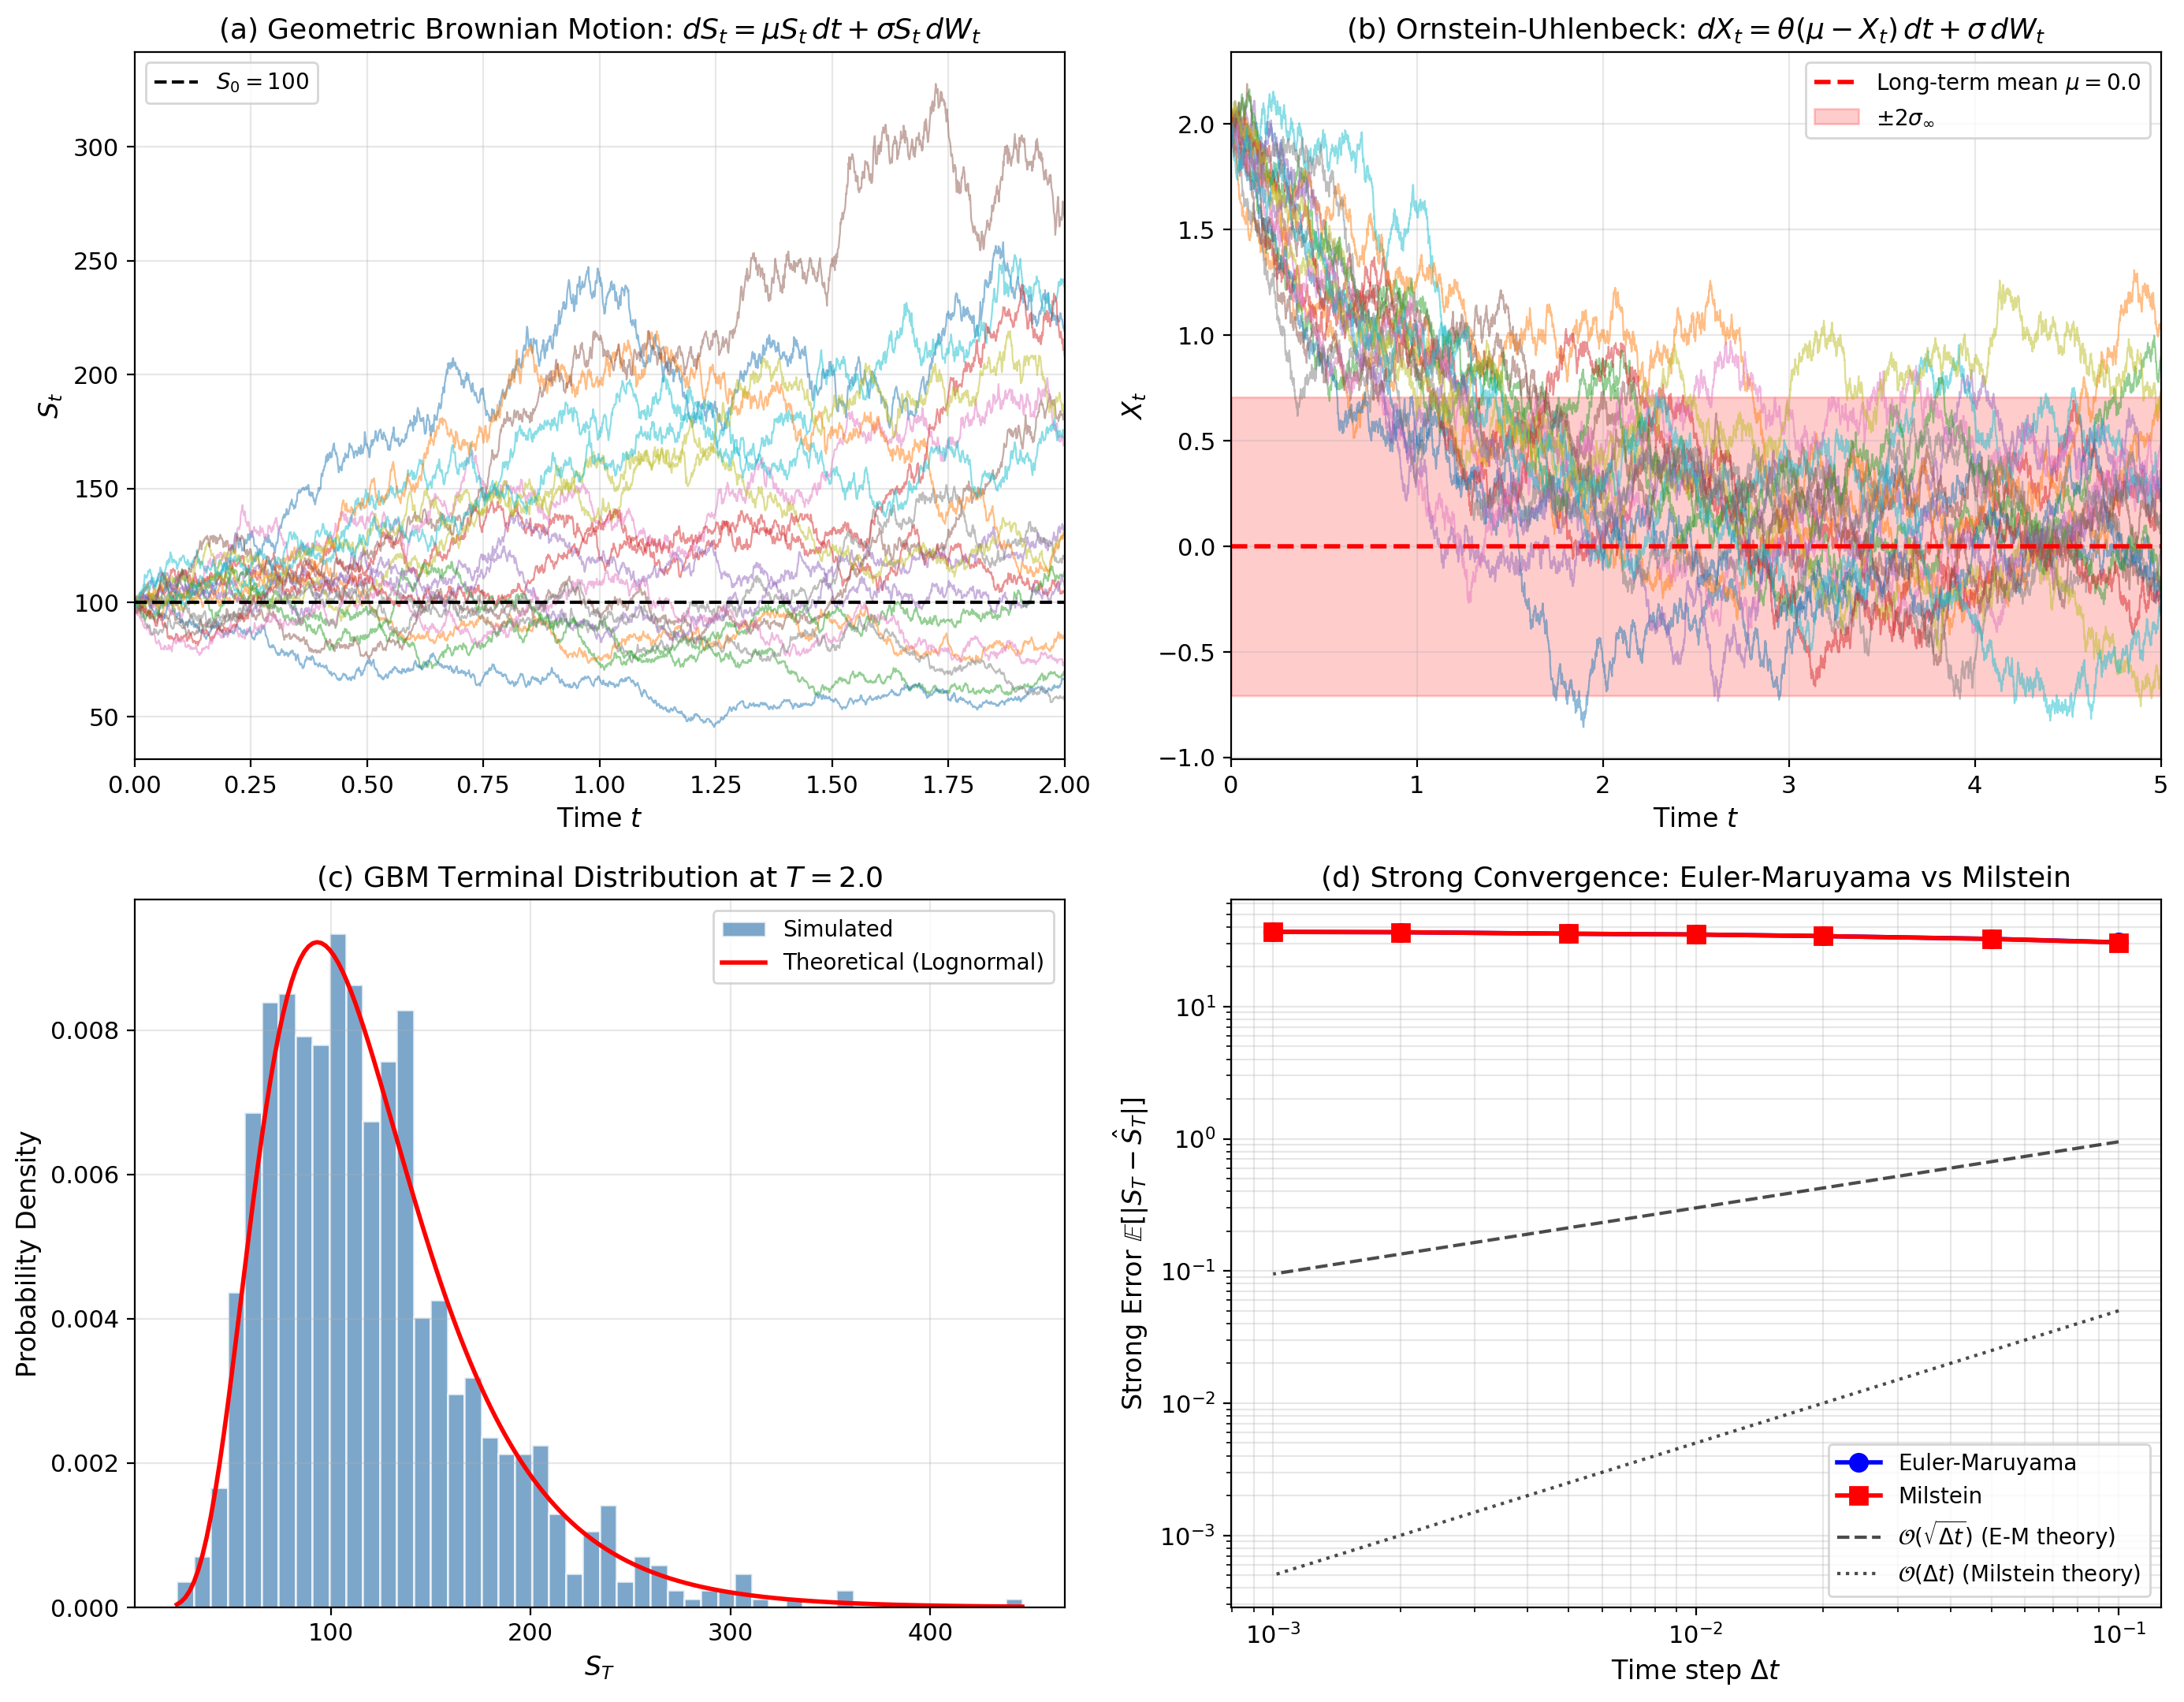


Figure saved to plot.png


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# Panel (a): GBM Sample Paths
ax1 = axes[0, 0]
n_show = 20
for i in range(n_show):
    ax1.plot(t_gbm, S_gbm[:, i], alpha=0.5, linewidth=0.8)
ax1.axhline(y=S0, color='k', linestyle='--', linewidth=1.5, label=f'$S_0 = {S0}$')
ax1.set_xlabel('Time $t$')
ax1.set_ylabel('$S_t$')
ax1.set_title(r'(a) Geometric Brownian Motion: $dS_t = \mu S_t\,dt + \sigma S_t\,dW_t$')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, T])

# Panel (b): OU Process Sample Paths
ax2 = axes[0, 1]
for i in range(n_show):
    ax2.plot(t_ou, X_ou[:, i], alpha=0.5, linewidth=0.8)
ax2.axhline(y=mu_ou, color='r', linestyle='--', linewidth=2, label=f'Long-term mean $\\mu = {mu_ou}$')
ax2.fill_between(t_ou, mu_ou - 2*stationary_std, mu_ou + 2*stationary_std, 
                  alpha=0.2, color='red', label='$\\pm 2\\sigma_{\\infty}$')
ax2.set_xlabel('Time $t$')
ax2.set_ylabel('$X_t$')
ax2.set_title(r'(b) Ornstein-Uhlenbeck: $dX_t = \theta(\mu - X_t)\,dt + \sigma\,dW_t$')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, T_ou])

# Panel (c): Terminal Distribution of GBM
ax3 = axes[1, 0]
S_final = S_gbm[-1, :]
ax3.hist(S_final, bins=50, density=True, alpha=0.7, color='steelblue', 
         edgecolor='white', label='Simulated')

# Theoretical lognormal distribution
s_range = np.linspace(S_final.min(), S_final.max(), 200)
# For GBM: log(S_T) ~ N(log(S0) + (mu - sigma^2/2)*T, sigma^2*T)
log_mean = np.log(S0) + (mu_gbm - sigma_gbm**2/2) * T
log_std = sigma_gbm * np.sqrt(T)
pdf_lognormal = stats.lognorm.pdf(s_range, s=log_std, scale=np.exp(log_mean))
ax3.plot(s_range, pdf_lognormal, 'r-', linewidth=2, label='Theoretical (Lognormal)')
ax3.set_xlabel('$S_T$')
ax3.set_ylabel('Probability Density')
ax3.set_title(f'(c) GBM Terminal Distribution at $T = {T}$')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Panel (d): Convergence Analysis
ax4 = axes[1, 1]
ax4.loglog(dt_values, errors_em, 'bo-', markersize=8, linewidth=2, label='Euler-Maruyama')
ax4.loglog(dt_values, errors_mil, 'rs-', markersize=8, linewidth=2, label='Milstein')

# Reference slopes
dt_ref = np.array(dt_values)
ax4.loglog(dt_ref, 3*np.sqrt(dt_ref), 'k--', linewidth=1.5, alpha=0.7, 
           label=r'$\mathcal{O}(\sqrt{\Delta t})$ (E-M theory)')
ax4.loglog(dt_ref, 0.5*dt_ref, 'k:', linewidth=1.5, alpha=0.7, 
           label=r'$\mathcal{O}(\Delta t)$ (Milstein theory)')

ax4.set_xlabel('Time step $\\Delta t$')
ax4.set_ylabel('Strong Error $\\mathbb{E}[|S_T - \\hat{S}_T|]$')
ax4.set_title('(d) Strong Convergence: Euler-Maruyama vs Milstein')
ax4.legend(loc='lower right')
ax4.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('stochastic_differential_equations_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nFigure saved to plot.png")

## 8. Summary and Key Takeaways

### 8.1 Main Results

1. **Geometric Brownian Motion**: The simulated paths correctly exhibit the multiplicative noise characteristic of GBM. The terminal distribution follows a **lognormal distribution**, consistent with the analytical solution. The simulated mean and variance closely match theoretical predictions.

2. **Ornstein-Uhlenbeck Process**: The mean-reverting behavior is clearly visible, with paths oscillating around the long-term mean $\mu = 0$. The process reaches its stationary distribution with variance $\sigma^2/(2\theta)$.

3. **Numerical Convergence**: 
   - **Euler-Maruyama** converges with strong order $\frac{1}{2}$: error $\sim \mathcal{O}(\sqrt{\Delta t})$
   - **Milstein** achieves strong order $1$: error $\sim \mathcal{O}(\Delta t)$
   - For problems requiring high pathwise accuracy, Milstein provides significant improvement

### 8.2 Practical Considerations

- **Time step selection**: Balance accuracy vs computational cost; $\Delta t \lesssim 0.01$ often suffices
- **Positivity preservation**: GBM can go negative with Euler-Maruyama for large $\sigma$ and $\Delta t$; consider log-transformation or implicit schemes
- **Multi-dimensional SDEs**: Milstein becomes more complex; Euler-Maruyama is often preferred

### 8.3 Extensions

- **Higher-order schemes**: Runge-Kutta methods for SDEs, stochastic Taylor expansions
- **Jump-diffusion models**: SDEs with Poisson jump components
- **Stochastic PDEs**: Infinite-dimensional SDEs for spatial-temporal phenomena